In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
auxiliary_files_path = '/data1/lmh_data/MINE/source/HepG2'

all_hr_sig = np.load('../fig3/tss/temp/HepG2_ATAC_H3K27ac_H3K4me3_2_100_all_hr_sig.npy', allow_pickle=True).item()

active_small_sred_tad_csv_path = '../fig4/active_small(special).csv'
infos = pd.read_csv(active_small_sred_tad_csv_path, sep=",", index_col=0)
infos

,0,1,2,3,4,5,RNA_rpkms,degree,TAD Volume,loop nums,score,Gene names
2339,chr7,121320000,128890000,91,2.306195,0.763548,2.603643,small,2.306195,91,209.863725,"IMPDH1,CICP14,GRM8,RNF148,WASL-DT,ZNF800,FLNC,..."
660,chr12,109390000,113100000,83,1.939004,0.793790,2.858114,small,1.939004,83,160.937317,"RPS2P41,ANKRD13A,TMEM116,RPL31P49,FAM222A-AS1,..."
2130,chr6,42900000,47790000,76,1.578383,0.823468,4.971112,small,1.578383,76,119.957109,"SLC29A1,CD2AP-DT,CD2AP,KLC4-AS1,PTK7,RRP36,KLH..."
596,chr12,48640000,50500000,68,1.651154,0.780923,2.997480,small,1.651154,68,112.278500,"TROAP,COX14,DNAJC22,SNORA2A,TUBA1A,BCDIN3D-AS1..."
1372,chr2,74890000,85060000,41,2.448587,0.550086,3.736622,small,2.448587,41,100.392077,"POLE4,MRPL19,SUPT4H1P1,LRRTM4,LINC01851,CYCSP6..."


In [3]:
def read_bed_file(path):
    _peaks = dict()
    with open(path)as f:
        for line in f:
            datas = line.strip().split()
            left, right = int(int(datas[1])/1000), int(int(datas[2])/1000)
            peaks = list(range(left, right+1))
            if datas[0] not in _peaks.keys():
                _peaks[datas[0]] = set()
            for i in peaks:
                _peaks[datas[0]].add(i)
    return _peaks

attentions = 50
center = attentions - 1

def get_hit_indicators(significants, peaks):
    distance = np.zeros(attentions*2-1)
    
    for sig in significants:
        x, y = int(sig[0]), int(sig[1])
        for i in range(attentions):
            if (x+i) in peaks or (y+i) in peaks:
                distance[center-i] += 1
            if i != 0 and((x-i) in peaks or (y-i) in peaks):
                distance[center+i] += 1
            if (x+i) in peaks or (x-i) in peaks or (y+i) in peaks or (y-i) in peaks:
                break
    return distance

def show(x, hr_result):
    sns.set_style("whitegrid") 
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
    axes.grid(False)
    axes.plot(x, hr_result, color=(177/255, 89/255, 40/255), label='hr')

    plt.xlabel('distance')
    plt.ylabel('nums')
    plt.legend()
    plt.show()

def test(all_hr_sig, chia_pet_peaks):
    screen_hr_sigs, screen_chia_pet_peaks = dict(), dict()
    for index in infos.index:
        _chr, _start, _end = infos.loc[index][0], int(int(infos.loc[index][1])/1000), int(int(infos.loc[index][2])/1000)
        for interaction in all_hr_sig[int(_chr[3:])]:
            if interaction[0] < _start or interaction[0] > _end:
                continue
            if interaction[1] < _start or interaction[1] > _end:
                continue
            if int(_chr[3:]) not in screen_hr_sigs.keys():
                screen_hr_sigs[int(_chr[3:])] = set()
            screen_hr_sigs[int(_chr[3:])].add((int(interaction[0]), int(interaction[1])))
        for peak in chia_pet_peaks[_chr]:
            if interaction[0] < _start or interaction[0] > _end:
                continue
            if int(_chr[3:]) not in screen_chia_pet_peaks.keys():
                screen_chia_pet_peaks[int(_chr[3:])] = set()
            screen_chia_pet_peaks[int(_chr[3:])].add((int(peak)))

    all_hr_result = np.zeros(attentions*2-1)
    for chr in range(1, 23):
        if chr not in screen_hr_sigs.keys() or chr not in screen_chia_pet_peaks.keys():
            continue
        hr_result = get_hit_indicators(screen_hr_sigs[chr], screen_chia_pet_peaks[chr])
        all_hr_result += hr_result

    show(list(range(-attentions+1, attentions)), all_hr_result)

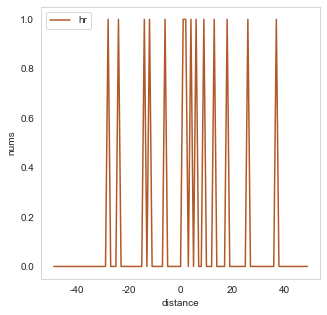

In [4]:
chia_pet_path = os.path.join(auxiliary_files_path, 'CTCF_chiapet_peaks.bed')
chia_pet_peaks = read_bed_file(chia_pet_path)
test(all_hr_sig, chia_pet_peaks)

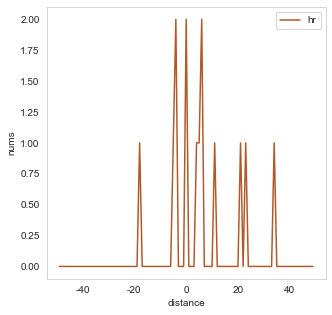

In [5]:
chia_pet_path = os.path.join(auxiliary_files_path, 'POLR2A_chiapet_peaks.bed')
chia_pet_peaks = read_bed_file(chia_pet_path)
test(all_hr_sig, chia_pet_peaks)